In [1]:
!pip install pystan==2.19.1.1 #We need old version 

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


# Small and shallow networks

In [2]:
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import numpy as np
import tensorflow as tf
import sys
from tensorflow.keras import backend as K
from tensorflow.keras.layers import Layer
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras import initializers
from tensorflow.keras import callbacks, optimizers

In [3]:
use_mcmc=True
# Number of epochs
epochs=50000

# Number of hidden units for the single hidden layer
num_hidden_units=3

# Number of samples psi to approximate the expected value
#num_samples_per_epoch=6

# Range for the PPD
num_xx=500
xx = np.linspace(-10, 10, num_xx).reshape(-1, 1)

# Number of predictions for the PPD
num_predictions=1000

optimizers = optimizers.RMSprop()

In [4]:
%load_ext autoreload
%autoreload 2


try: #If running in colab
    import google.colab
    IN_COLAB = True
    %tensorflow_version 2.x
    #upload vimlts.py first
    !wget https://raw.githubusercontent.com/stefan1893/TM-VI/main/src/vimlts.py
    !wget https://raw.githubusercontent.com/stefan1893/TM-VI/main/src/vigauss_keras.py
    !wget https://raw.githubusercontent.com/stefan1893/TM-VI/main/src/vimlts_keras.py
    !wget https://raw.githubusercontent.com/stefan1893/TM-VI/main/src/vimlts_utils_keras.py
    !wget https://github.com/stefan1893/TM-VI/blob/main/ipynb/02_small_and_shallow_networks.npz?raw=true -O 02_small_and_shallow_networks.npz

    sys.path.append(".")
    import vimlts_utils_keras as VIMLTS_utils
    from vimlts import VIMLTS
    from vigauss_keras import DenseVIGAUSS
    from vimlts_keras import DenseVIMLTS
except:
    IN_COLAB = False
    sys.path.append('../')
    import src.vimlts_utils_keras as VIMLTS_utils
    from src.vimlts import VIMLTS
    from src.vigauss_keras import DenseVIGAUSS
    from src.vimlts_keras import DenseVIMLTS
    #Use GPU
    physical_devices = tf.config.list_physical_devices('GPU')
    tf.config.experimental.set_memory_growth(physical_devices[0], True)

import tensorflow_probability as tfp
import tensorflow.keras as keras
import pandas as pd
import pystan
import scipy.stats as stats
import scipy.signal
import seaborn as sns
import tqdm
import datetime
import sys
import ctypes
import pickle
from IPython.display import display, clear_output, HTML
from numpy import trapz
from scipy.stats import norm


tfd=tfp.distributions

print('Tensorflow version: ',tf.__version__, )

Colab only includes TensorFlow 2.x; %tensorflow_version has no effect.
--2022-08-10 09:58:00--  https://raw.githubusercontent.com/stefan1893/TM-VI/main/src/vimlts.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 8100 (7.9K) [text/plain]
Saving to: ‘vimlts.py.2’

vimlts.py.2         100%[===================>]   7.91K  --.-KB/s    in 0s      

2022-08-10 09:58:00 (101 MB/s) - ‘vimlts.py.2’ saved [8100/8100]

--2022-08-10 09:58:00--  https://raw.githubusercontent.com/stefan1893/TM-VI/main/src/vigauss_keras.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting r

## Data generating process

In [5]:
def get_toy_data_3(
    noise_scale,
    train_size,
    test_size,
    true_size,
    use_hole
):
    tf.random.set_seed(2)

    train_xlim = 6.
    test_xlim = 6.5
    true_xlim = 6.5

    # True function
    target_fn = lambda x: np.sin(x)

    # Train samples
    if use_hole:
        half_train_size = train_size // 2
        train_xs_left = tfd.Uniform(low = -train_xlim, high = -train_xlim/3).sample(sample_shape = (half_train_size, 1))
        train_xs_right = tfd.Uniform(low = train_xlim/3, high = train_xlim).sample(sample_shape = (half_train_size, 1))
        train_xs = np.concatenate((train_xs_left, train_xs_right))
    else:
        train_xs = np.linspace(-train_xlim,train_xlim,train_size)
        train_xs = np.reshape(train_xs,[-1,1])


    train_ys = target_fn(train_xs)
    train_ys += noise_scale * tfd.Normal(loc=0.,scale=1.).sample(sample_shape = (train_size, 1))

    # Test samples
    test_xs = np.linspace(-test_xlim,test_xlim,test_size)
    test_xs = np.reshape(test_xs,[-1,1])
    test_ys = target_fn(test_xs)
    test_ys += noise_scale * tfd.Normal(loc=0.,scale=1.).sample(sample_shape = (test_size, 1))

    # True
    true_xs = np.linspace(-true_xlim, true_xlim, true_size)
    true_xs = np.reshape(true_xs, (true_size, 1))
    true_ys = target_fn(true_xs)


    return train_xs, train_ys, test_xs, test_ys, true_xs, true_ys

load data


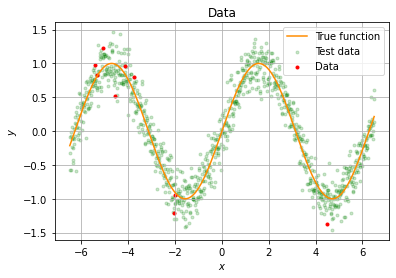

In [6]:
sigma = noise  = .2
num = train_size = 9
test_size = 1000
true_size = 1000

data_file = "02_small_and_shallow_networks.npz"
try:
    def unpack(x, y, x_test, y_test, x_true, y_true):
        return x, y, x_test, y_test, x_true, y_true
    x, y, x_test, y_test, x_true, y_true = unpack(**np.load(data_file))
    x = x[0:9, ] #<--- Only 9
    y = y[0:9]
    print("load data")
except Exception as e:
    print("create data")
    print(e)
    x, y, x_test, y_test, x_true, y_true = get_toy_data_3(sigma, train_size, test_size, true_size,use_hole=1)
    np.savez(data_file, x=x,y=y,x_test=x_test, y_test=y_test, x_true=x_true ,y_true=y_true)
y=np.reshape(y,[-1])
y_test=np.reshape(y_test,[-1])

plt.figure()
plt.scatter(x_test,y_test, marker='.', color='g',label=r"Test data",alpha=0.2)
plt.scatter(x,y, marker='.', color='r',label=r"Data")
plt.plot(x_true,y_true,color="darkorange",label=r"True function")
plt.grid()
plt.legend()
plt.ylabel(r"$y$")
plt.xlabel(r"$x$")
plt.title(r'Data');

In [7]:
len(y)

9

## Common hyperparameter

In [8]:
# Train parameters
batch_size = train_size
num_batches = train_size / batch_size
kl_weight = 1.0 / num_batches

# Prior
prior_params = {
    'prior_mu': 0., 
    'prior_sigma': 1.
}

## Common functions

In [9]:
def neg_log_likelihood(y_obs, y_pred, sigma=noise):
    dist = tfp.distributions.Normal(loc=y_pred, scale=sigma)
    return K.sum(-dist.log_prob(y_obs))

## Ground truth


In [10]:
def plot_trace(param, param_name='parameter'):
    """Plot the trace and posterior of a parameter."""

    # Summary statistics
    mean = np.mean(param)
    median = np.median(param)
    cred_min, cred_max = np.percentile(param, 2.5), np.percentile(param, 97.5)

    # Plotting
    plt.subplot(2,1,1)
    plt.plot(param)
    plt.xlabel(r'samples')
    plt.ylabel(param_name)
    plt.axhline(mean, color='r', lw=2, linestyle='--')
    plt.axhline(median, color='c', lw=2, linestyle='--')
    plt.axhline(cred_min, linestyle=':', color='k', alpha=0.9)
    plt.axhline(cred_max, linestyle=':', color='k', alpha=0.9)
    plt.title(r'Trace and Posterior Distribution for {}'.format(param_name))

    plt.subplot(2,1,2)
    plt.hist(param, 30,zorder=1, density=True); sns.kdeplot(param,color='g',zorder=2, shade=True, label=r'kde')
    plt.xlabel(param_name)
    plt.ylabel(r'density')
    plt.axvline(mean, color='r', lw=2, linestyle='--',label=r'mean')
    plt.axvline(median, color='c', lw=2, linestyle='--',label=r'median')
    plt.axvline(cred_min, linestyle=':', color='k', alpha=0.9, label=r'95% CI')
    plt.axvline(cred_max, linestyle=':', color='k', alpha=0.9)

    plt.gcf().tight_layout()
    plt.legend()

In [11]:
if use_mcmc:
  stan_code = """
  functions {
    matrix selfmade_relu(matrix z, int a_rows, int a_columns){
      matrix[a_rows, a_columns] a;
      for (i in 1:a_rows){
        for (j in 1:a_columns){
          if(z[i,j]>0){
            a[i,j]=z[i,j];
          }
          else{
            a[i,j]=0;
          }
        }
      }
      return a;
    }
    
    vector calculate_mu(matrix X, matrix bias_first_m, real bias_output, matrix w_first, vector w_output, int num_layers) {
		int N = rows(X);
		int num_nodes = rows(w_first);

		matrix[N, num_nodes] layer_values[num_layers - 2];
		vector[N] mu;

		//layer_values[1] = selfmade_relu(bias_first_m + X * w_first',N,num_nodes);  
    layer_values[1] = inv_logit(bias_first_m + X * w_first');   

		mu = bias_output + layer_values[num_layers - 2] * w_output;

      return mu;
    }
  }
  data {
    int<lower=0> N;						// num data
    int<lower=0> d;						// dim x
    int<lower=0> num_nodes;				// num hidden unites
    int<lower=1> num_middle_layers;		// num hidden layer
    matrix[N,d] X;						// X
    real y[N];							// y
	int<lower=0> Nt;					// num predicive data
	matrix[Nt,d] Xt;					// X predicive
	real<lower=0> sigma;				// const sigma
  }
  transformed data {
    int num_layers;
    num_layers = num_middle_layers + 2;
  }
  parameters {
    vector[num_nodes] bias_first;
    real bias_output;
    matrix[num_nodes, d] w_first;
    vector[num_nodes] w_output;
	// hyperparameters
    real<lower=0> bias_first_h;
    real<lower=0> w_first_h;
    real<lower=0> w_output_h;
  } 
  transformed parameters {
    matrix[N, num_nodes] bias_first_m = rep_matrix(bias_first', N);
  }
  model{
    vector[N] mu;
    mu = calculate_mu(X, bias_first_m, bias_output, w_first, w_output, num_layers);
    y ~ normal(mu,sigma);
    
    //priors
    bias_first_h ~ normal(0, 1);
    bias_first ~ normal(0, 1);
    bias_output ~ normal(0, 1);

    w_first_h ~ normal(0, 1);
    to_vector(w_first) ~ normal(0, 1);

    w_output_h ~ normal(0, 1);
    w_output ~ normal(0, 1);
  }
  generated quantities{
    vector[Nt] predictions;
	matrix[Nt, num_nodes] bias_first_mg = rep_matrix(bias_first', Nt);
	vector[Nt] mu;

	mu = calculate_mu(Xt, bias_first_mg, bias_output,w_first, w_output, num_layers);
	for(i in 1:Nt){ 
		predictions[i] = normal_rng(mu[i],sigma);
	}
  }
  """
  model_mcmc=pystan.StanModel(model_code=stan_code)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_fb4992f066e706ad7835e6d9163a9f06 NOW.


In [12]:
num_hidden_units

3

In [13]:
if use_mcmc:
  my_dat = {'N': num,
          'd': 1,
          'num_nodes': num_hidden_units,
          'num_middle_layers':1,
          'X': x,
          'y': y,
          'sigma': sigma,
          'Nt': num_xx,
          'Xt': xx
          }

  fit_mcmc=model_mcmc.sampling(data=my_dat,iter=5000,chains=4)

To run all diagnostics call pystan.check_hmc_diagnostics(fit)


In [14]:
if use_mcmc:    
    samples_predictions=fit_mcmc.extract()['predictions']; 
    print(samples_predictions.shape)
    samples_predictions_mean=np.mean(samples_predictions,axis=0)
    samples_predictions_2p5=np.quantile(samples_predictions,0.025,axis=0)
    samples_predictions_97p5=np.quantile(samples_predictions,0.975,axis=0)
    samples_predictions_50p0=np.quantile(samples_predictions,0.5,axis=0)

(10000, 500)


In [15]:
if use_mcmc:    
  import pandas as pd
  df = pd.DataFrame(data=[xx.ravel(),samples_predictions_mean, 
                   samples_predictions_2p5, 
                   samples_predictions_50p0, 
                   samples_predictions_97p5])
  df.transpose().to_csv('mcmc_y_quantiles.csv')

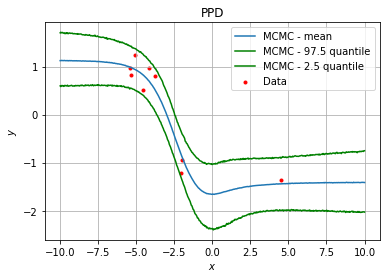

In [16]:
if use_mcmc:
    plt.plot(xx,samples_predictions_mean,label="MCMC - mean")
    plt.plot(xx,samples_predictions_97p5,color='g',label="MCMC - 97.5 quantile")
    #plt.plot(xx,samples_predictions_50p0,color='g',label="mcmc_50p0_quantile")
    plt.plot(xx,samples_predictions_2p5,color='g',label="MCMC - 2.5 quantile")
    plt.scatter(x,y, marker='.', color='r', label="Data")
    plt.legend()
    plt.grid()
    plt.ylabel(r"$y$")
    plt.xlabel(r"$x$")
    plt.title(r'PPD');

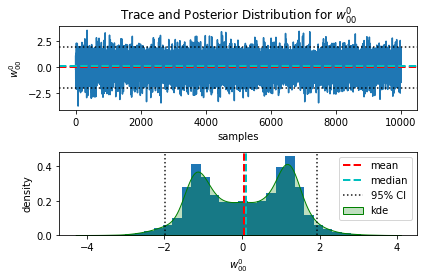

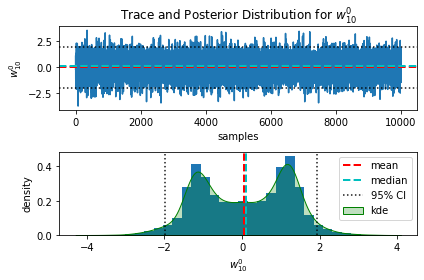

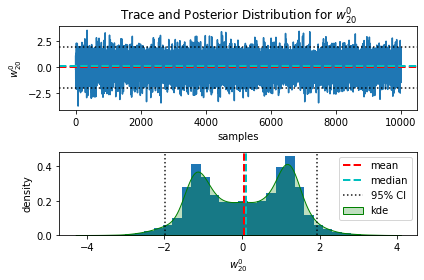

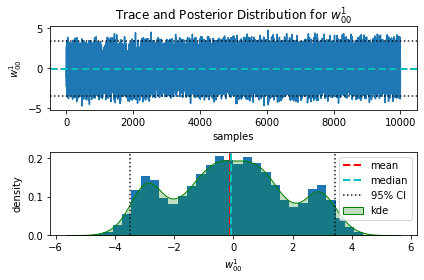

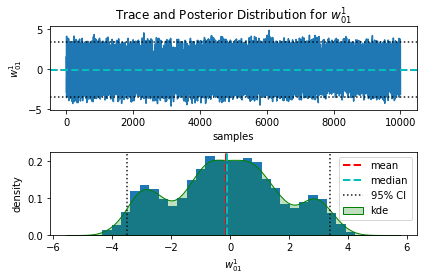

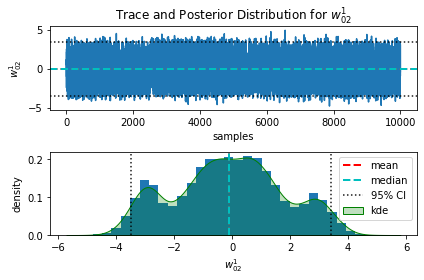

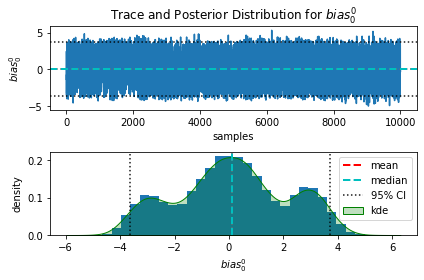

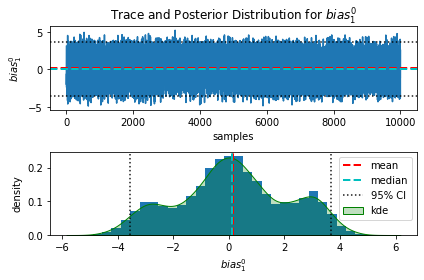

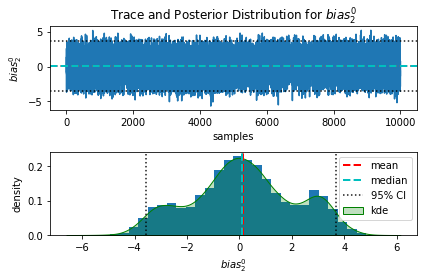

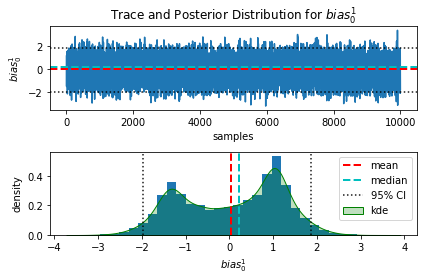

In [17]:
if use_mcmc:
    for i in range(num_hidden_units):
        plt.figure()
        plot_trace(fit_mcmc.extract()['w_first'][:,0,0],r"$w^{0}_{"+str(i)+r"0}$")

    for i in range(num_hidden_units):
        plt.figure()
        plot_trace(fit_mcmc.extract()['w_output'][:,i],r"$w^{1}_{0"+str(i)+r"}$")

    for i in range(num_hidden_units):
        plt.figure()
        plot_trace(fit_mcmc.extract()['bias_first'][:,i],r"$bias^{0}_{"+str(i)+r"}$")

    plt.figure()
    plot_trace(fit_mcmc.extract()['bias_output'],r"$bias^{1}_{0}$")

## VIGAUSS

MFVI with a Gaussian as variational distribution

In [18]:
x_in = Input(shape=(1,),name="VIGAUSS_il")
x_arch = DenseVIGAUSS(units=num_hidden_units, activation='sigmoid', kl_weight=kl_weight, name="VIGAUSS_hl_1", **prior_params )(x_in)
x_arch = DenseVIGAUSS(units=1, kl_weight=kl_weight, name="VIGAUSS_ol", **prior_params)(x_arch)

model_VIGAUSS = Model(x_in, x_arch,name="model_VIGAUSS")

In [19]:
print(model_VIGAUSS.summary())

Model: "model_VIGAUSS"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 VIGAUSS_il (InputLayer)     [(None, 1)]               0         
                                                                 
 VIGAUSS_hl_1 (DenseVIGAUSS)  (None, 3)                12        
                                                                 
 VIGAUSS_ol (DenseVIGAUSS)   (None, 1)                 8         
                                                                 
Total params: 20
Trainable params: 20
Non-trainable params: 0
_________________________________________________________________
None


In [20]:
model_VIGAUSS.compile(loss=neg_log_likelihood, optimizer=optimizers, metrics=[neg_log_likelihood])

In [21]:
callbacks_VIGAUSS = [
    #callbacks.LearningRateScheduler(lr_scheduler, verbose=0)
]

# Fit the model to the data
hist=model_VIGAUSS.fit(x, y, callbacks=callbacks_VIGAUSS, batch_size=batch_size, epochs=epochs, verbose=0);

### Analyse the loss

Loss nach Training VIGAUSS:	 30.129608154296875


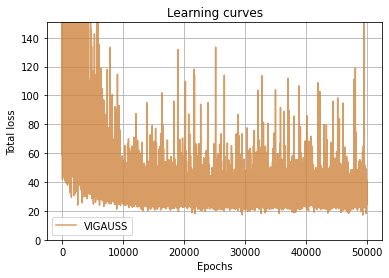

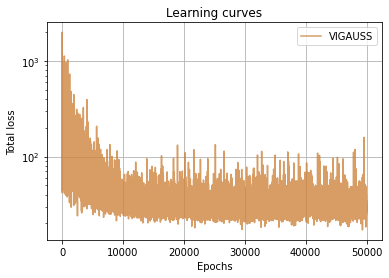

In [22]:
loss_model_VIGAUSS=hist.history['loss'][np.shape(hist.history['loss'])[0]-1]
print("Loss nach Training VIGAUSS:\t",loss_model_VIGAUSS)

plt.figure()
plt.plot(hist.history['loss'],alpha=0.8,color='peru',label=r"VIGAUSS")
plt.xlabel(r'Epochs')
plt.ylabel(r'Total loss')
plt.title(r'Learning curves');
plt.grid()
plt.legend()
plt.ylim([0, loss_model_VIGAUSS*5])

plt.figure()
plt.plot(hist.history['loss'],alpha=0.8,color='peru',label=r"VIGAUSS")
plt.xlabel(r'Epochs')
plt.ylabel(r'Total loss')
plt.title(r'Learning curves');
plt.grid()
plt.legend()
plt.yscale('log')


Show a noise reduced curve

## Predictive

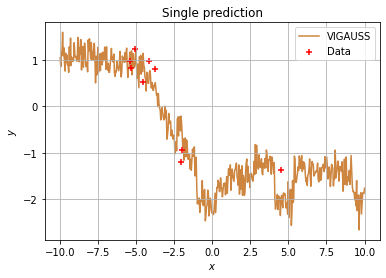

In [23]:
mu_VIGAUSS = model_VIGAUSS.predict(xx)
y_pred_VIGAUSS = tfp.distributions.Normal(mu_VIGAUSS,sigma).sample()
plt.plot(xx,y_pred_VIGAUSS,zorder=0,label=r'VIGAUSS',color='peru')
plt.scatter(x, y, marker='+',c='r',zorder=1, label=r'Data')
plt.grid()
plt.legend()
plt.ylabel(r"$y$")
plt.xlabel(r"$x$")
plt.title(r'Single prediction');

In [24]:
# VIMLTS
y_pred_list = []

# VIGAUSS
y_pred_list_VIGAUSS = []

# Iterate over number of predictions
for i in tqdm.tqdm(range(num_predictions)):
    # VIGAUSS
    mu_VIGAUSS = model_VIGAUSS.predict(xx)
    y_pred_VIGAUSS = tfp.distributions.Normal(mu_VIGAUSS,sigma).sample()
    y_pred_list_VIGAUSS.append(y_pred_VIGAUSS)

100%|██████████| 1000/1000 [01:09<00:00, 14.32it/s]


In [25]:
# VIGAUSS
y_preds_VIGAUSS = np.concatenate(y_pred_list_VIGAUSS, axis=1)
y_predictions_mean_VIGAUSS=np.mean(y_preds_VIGAUSS,axis=1)
y_predictions_05_VIGAUSS=np.quantile(y_preds_VIGAUSS,0.05,axis=1)
y_predictions_95_VIGAUSS=np.quantile(y_preds_VIGAUSS,0.95,axis=1)
y_predictions_50_VIGAUSS=np.quantile(y_preds_VIGAUSS,0.5,axis=1)

np.savetxt('y_predictions_05_VIGAUSS.csv', y_predictions_05_VIGAUSS, delimiter=',')
np.savetxt('y_predictions_95_VIGAUSS.csv', y_predictions_95_VIGAUSS, delimiter=',')
np.savetxt('y_predictions_50_VIGAUSS.csv', y_predictions_50_VIGAUSS, delimiter=',')
np.savetxt('xx.csv', xx, delimiter=',')